In [1]:
import networks as nt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 42, 'ps.fonttype': 42})
plt.rcParams.update({'font.size': 10, 'font.family': 'Helvetica'})

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
dim = 10
RED = [2, 4, 8, 16, 32, 64]

recycle_runs = True
starting_seed = 1
no_networks_per_red = 20
threshold = 0.7

time_r = 0.4
time_c = 1
dt = 1e-4
s_mag = 5
signal_noise = 0
reset = 0
lambd = 10
ref_t = 0.002
noise = 0

In [3]:
T_r = int(time_r / dt)
T_c = int(time_c / dt)
no_red = len(RED)
colors = plt.cm.Set1(np.linspace(0,1,no_red))

In [4]:
def sim_current(F, Omega, Th, X, dt, dV, lambd, R0, V0, ref_t=ref_t, seed=1):
    '''
    Inputs: 
        F: (N, M) array. Encoding Weights. N is the number of neurons and M is the signal dimension
        Omega: (N, N) array. Recurrent Connections. N is the number of neurons
        Th: (N,) array. Neuron Thresholds. N is the number of neurons
        X: (T, M) array. Signal to be represented. T is the number of time steps and M is the signal dimension
        dt: scalar. Time step of the simulation
        dV: (T, N) array. Additive term on the voltages traces (should already be multiplied by the time step)
        lambd: positive scalar. Decoder time constant
        R0: (N,) array. Initial Rate Values
        V0: (N,) array. Initial Voltage values
        ref_t: non-negative scalar. refractory period duration in seconds
    Outputs:
        R: ((T + jump - 1) // jump, N) array. Firing Rates approximation of each neuron. T is the number of time steps and N is the number of neurons
        Spikes: list of lists. Each element in Spikes is a list containing the simulation time where that neuron fired
        Rn: (N,) array. Final Rates of the simulation
        Vn: (N,) array. Final Voltages of the simulation
    '''
    np.random.seed(seed)
    ref = max(int(np.ceil(ref_t / dt)), 1) # minimum number of time steps between same-neuron spikes
    dtlamb = 1 - dt * lambd
    N = F.shape[0]  # N is the number of Neurons
    T = X.shape[0]  # T is the total time iterations
    Vc = V0.copy() # Array with the current Voltages
    Rc = R0.copy() # Array with the current Rates
    R = np.zeros((T, N))  # Array with the approximation of the firing rates
    Spikes = [[] for i in range(N)]  # list of lenght Neurons of list of lenght no_spikes
    FX = np.dot(X, F.T)  # Network inputs
    Ref = -1 * np.ones(N)
    Th_c = Th
    saturation = np.zeros(N)
    BAL = np.zeros((T, N, 2))
    for i in range(T):
        # SN is a list containing neurons that should fire
        VR = ((Vc > Th_c) & (Ref <= 0))
        while np.any(VR):
            SN = np.where(VR)[0]
            SNN = np.where(Vc[SN] == np.max(Vc[SN]))[0]
            sn = SN[np.random.choice(SNN)]
            Rc[sn] += 1
            Spikes[sn].append(i)
            Ref[sn] = ref
            # Adding the resets of each spike through Omega
            Vc -= Omega[:, sn]
            BAL[i, :, 0] += np.minimum(-Omega[:, sn], 0)
            BAL[i, sn, 0] += Omega[sn, sn]
            BAL[i, :, 1] += np.maximum(-Omega[:, sn], 0)
            VR = ((Vc > Th_c) & (Ref <= 0))
        if np.any(Vc > Th_c):
            for j in range(N):
                if Vc[j] > Th_c[j]:
                    saturation[j] += 1
        Rc *= dtlamb
        Vc = dtlamb * Vc + dt * FX[i, :] + dV[i, :]
        BAL[i, :, 0] += np.minimum(dt * FX[i, :], 0)
        BAL[i, :, 1] += np.maximum(dt * FX[i, :], 0)
        Ref -= 1
        R[i, :] = Rc
    print('dt', dt, 'ref', ref, 'delay', 0, 'N', N, 'most saturated neuron: ', np.max(saturation) / T, 'average saturated neuron:', np.mean(saturation) / T)
    return R, Spikes, BAL, Rc, Vc

In [5]:
def current_trial(dim, N, seed):
    '''
    Output:
        E: average L2 error across trial
        Rates: (N,) vector of average firing rates across trial
        x: signal being encoded
        F: encoder weight matrix
        BAL: positive and negative current arriving at each neuron throughout the trial (T, N, 2)
    '''
    str_trial = str((dim, N, seed, s_mag, signal_noise, reset, threshold, lambd, ref_t, noise, time_r, time_c, dt))    
    str_trial = nt.clean_string(str_trial)
    run_k = True
    if recycle_runs:
        try:
            res_k = np.load('aux/current/{}.npz'.format(str_trial))
            E = res_k['E']
            Rates = res_k['Rates']
            x = res_k['x']
            F = res_k['F']
            BAL = res_k['BAL']
            run_k = False
        except:
            pass
    if run_k:
        print(str_trial)
        # Section 1: Ramping Activity
        X_r, C_r = nt.ramping_signal(dim, T_r, dt, s_mag=s_mag, seed_signal=seed)
        x = X_r[-1, :]
        C_r += lambd * X_r
        F, Omega, Th, D = nt.create_param(dim, N, threshold=threshold, reset=reset, seed_network=seed)
        dV_r = np.sqrt(dt) * noise * np.random.randn(T_r, N)
        R_r, Spikes_r, BAL_r, R0, V0 = sim_current(F, Omega, Th, C_r, dt, dV_r, lambd, np.zeros(N), np.zeros(N), ref_t=ref_t, seed=seed)
        X = nt.constant_signal(x, T_c, dt, signal_noise=signal_noise, seed=seed)
        C = lambd * X
        N = F.shape[0]
        dV = np.sqrt(dt) * noise * np.random.randn(T_c, N)
        R, Spikes, BAL, R0, V0 = sim_current(F, Omega, Th, C, dt, dV, lambd, R0, V0, ref_t=ref_t, seed=seed)
        
        Xh_c = nt.readout_correction(R, D, threshold)
        Epsilon = X - Xh_c
        l2 = np.linalg.norm(Epsilon, axis=1)
        E = np.mean(l2)
        
        Rates = np.array([len(i) / time_c for i in Spikes])
                
        np.savez('aux/current/{}.npz'.format(str_trial), E=E, Rates=Rates, x=x, F=F, BAL=BAL)
    return E, Rates, x, F, BAL

D:10, N:20, seed:1
D:10, N:20, seed:2
D:10, N:20, seed:3
D:10, N:20, seed:4
D:10, N:20, seed:5
D:10, N:20, seed:6
D:10, N:20, seed:7
D:10, N:20, seed:8
D:10, N:20, seed:9
D:10, N:20, seed:10
D:10, N:20, seed:11
D:10, N:20, seed:12
D:10, N:20, seed:13
D:10, N:20, seed:14
D:10, N:20, seed:15
D:10, N:20, seed:16
D:10, N:20, seed:17
D:10, N:20, seed:18
D:10, N:20, seed:19
D:10, N:20, seed:20
D:10, N:40, seed:1
D:10, N:40, seed:2
D:10, N:40, seed:3
D:10, N:40, seed:4
D:10, N:40, seed:5
D:10, N:40, seed:6
D:10, N:40, seed:7
D:10, N:40, seed:8
D:10, N:40, seed:9
D:10, N:40, seed:10
D:10, N:40, seed:11
D:10, N:40, seed:12
D:10, N:40, seed:13
D:10, N:40, seed:14
D:10, N:40, seed:15
D:10, N:40, seed:16
D:10, N:40, seed:17
D:10, N:40, seed:18
D:10, N:40, seed:19
D:10, N:40, seed:20
D:10, N:80, seed:1
D:10, N:80, seed:2
D:10, N:80, seed:3
D:10, N:80, seed:4
D:10, N:80, seed:5
D:10, N:80, seed:6
D:10, N:80, seed:7
D:10, N:80, seed:8
D:10, N:80, seed:9
D:10, N:80, seed:10
D:10, N:80, seed:11
D:10, N

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


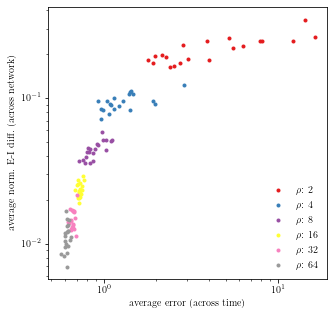

In [6]:
fig_final, ax_final = plt.subplots(1, 1, figsize=(5, 5))
    
Es = np.zeros((no_red, no_networks_per_red))
Avg_Bals = np.zeros((no_red, no_networks_per_red))

for j, red in enumerate(RED):
    N = dim * red
    for i_seed, seed in enumerate(range(starting_seed, starting_seed + no_networks_per_red)):
        print('D:{}, N:{}, seed:{}'.format(dim, N, seed))
        Es[j, i_seed], Rates, x, F, BAL = current_trial(dim, N, seed)
        BAL_aux = np.sum(BAL, axis=0)
        Ind_Bals = (BAL_aux[:, 1] + BAL_aux[:, 0]) / (BAL_aux[:, 1] - BAL_aux[:, 0])
        Avg_Bals[j, i_seed] = np.mean(np.abs(Ind_Bals))
    
    ax_final.loglog(Es[j, :], Avg_Bals[j, :], '.', color=colors[j, :], label=r'$\rho$: {}'.format(red))

ax_final.set_ylabel('average norm. E-I diff. (across network)')
ax_final.set_xlabel('average error (across time)')

handles, labels = ax_final.get_legend_handles_labels()
ax_final.legend(frameon=False)

fig_final.savefig('FIG4D.pdf', transparent=True)